In [33]:
# Load packages and directories


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import clustering_processing as cp, preprocessing, cluster_grid

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"


In [5]:
training_df = pd.read_csv(os.path.join(base_directory, 'combined_aircon_profiles_training.csv'))
prelim_PC_assignments = pd.read_csv(os.path.join(base_directory, 'prelim_profile_class_assignments.csv'))

# Convert 'date' column to datetime type
training_df['Timestamp'] = pd.to_datetime(training_df['Timestamp'])

prelim_PC_assignments = prelim_PC_assignments.rename(columns={'Unnamed: 0': 'date'})
# convert to date time format
prelim_PC_assignments['date'] = pd.to_datetime(prelim_PC_assignments['date'])

In [ ]:
print(prelim_PC_assignments)

In [ ]:
# Filter out zeros in the DataFrame
filtered_df = prelim_PC_assignments.replace(0, np.nan)

# Find the mode for each column, excluding zeros
modes = filtered_df.mode().iloc[0]  # Get the first mode for each column

# Find the mode of the modes (most frequent mode value across all columns)
mode_of_modes = modes.mode()[0]  # Get the most frequent mode value
print(mode_of_modes)

3.0


In [3]:
def prepare_time_series_for_clustering(training_df, prelim_PC_assignments):
    """
    Prepare time series data for clustering based on profile class 4
    
    Parameters:
    -----------
    training_df : pandas DataFrame
        Half-hourly time stamps data with site_ids as columns
    prelim_PC_assignments : pandas DataFrame
        Daily profile class assignments for each site
    
    Returns:
    --------
    time_series_dict : dict
        Dictionary of time series with keys as 'YYYY-MM-DD_SiteID'
    """

    
    # Create a dictionary to store time series
    time_series_dict = {}
    
        
        # find the mode of each column and return the mode of all the columns
    filtered_df = prelim_PC_assignments.replace(0, np.nan)

    # Find the mode for each column, excluding zeros
    modes = filtered_df.mode().iloc[0]  # Get the first mode for each column

    # Find the mode of the modes (most frequent mode value across all columns)
    mode_of_modes = modes.mode()[0]  # Get the most frequent mode value
    
    # Iterate through each site
    for site_id in prelim_PC_assignments.columns:
        if site_id == 'date':
            continue
        

        # Find dates where the site has mode profile class
        mode_dates = prelim_PC_assignments[prelim_PC_assignments[site_id] == mode_of_modes]['date']
        
        # Extract time series for these dates
        for date in mode_dates:
            # Get the time series for this site on this date
            daily_series = training_df[
                (training_df['Timestamp'].dt.date == date.date()) & 
                (training_df[site_id].notna())
            ][site_id].values
            
            if len(daily_series) > 0:
                # Create a unique key for each time series
                key = f'{date.date()}_{site_id}'
                time_series_dict[key] = daily_series
    
    return time_series_dict

In [ ]:
mode_time_series = prepare_time_series_for_clustering(training_df, prelim_PC_assignments)

print(mode_time_series)

In [ ]:
importlib.reload(cp)
from clustering_processing import print_cluster_comparison_report, compare_cluster_sizes, evaluate_clustering_kmeans, mean_index_adequacy, aggregate_rlps, visualize_profile_classes, evaluate_clustering_dtw, evaluate_clustering_kmedoids, evaluate_clustering_kmeans_constrained, evaluate_clustering_kmeans_load_factor, calculate_load_factor

cluster_type = "kmeans_load_factor"
min_clusters = 2
max_clusters = 6
cluster_results, best_clusters, Profile_Classes = compare_cluster_sizes(mode_time_series, cluster_type, min_clusters, max_clusters, save_plots=False, plot_dir=None, size_max = None)
print_cluster_comparison_report(cluster_results, best_clusters)

Evaluating 3 clusters...
Evaluating 4 clusters...
Evaluating 5 clusters...

=== Cluster Comparison Report ===

Metrics Summary:
--------------------------------------------------
   Silhouette Score  Davies-Bouldin Index  Mean Index Adequacy  Combined Index  Silhouette Rank  Davies-Bouldin Rank  MIA Rank  Combined Index Rank
3            0.2248                2.4424               0.6628          7.2001              1.0                  3.0       3.0                  2.0
4            0.2014                2.2033               0.6400          7.0021              2.0                  2.0       2.0                  1.0
5            0.1824                2.1262               0.6222          7.2515              3.0                  1.0       1.0                  3.0

Optimal Number of Clusters by Metric:
--------------------------------------------------
Silhouette Score: 3 clusters
Score: 0.2248
Davies-Bouldin Index: 5 clusters
Score: 2.1262
Mean Index Adequacy: 5 clusters
Score: 0.6222
Com

In [37]:
rlp_aggregated = aggregate_rlps(mode_time_series)

(<Figure size 1200x600 with 1 Axes>,
 <Axes: xlabel='Time of the Day', ylabel='Household Air Conditioner Electricity Consumption (Scaled)'>)

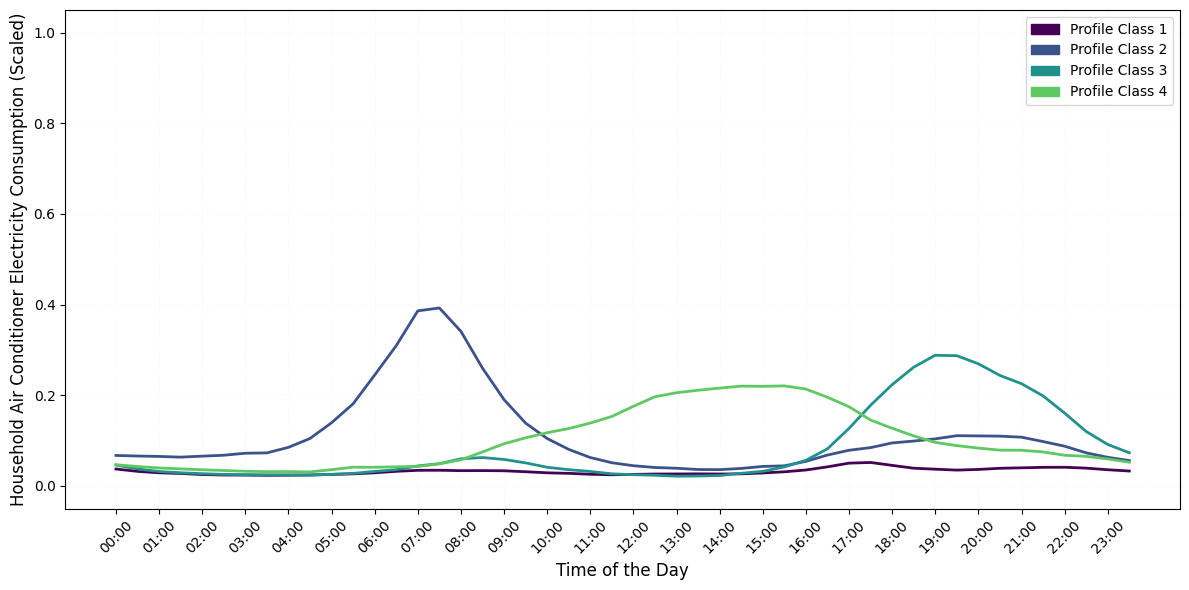

In [39]:
importlib.reload(cp)
# set Date as index
cp.visualize_profile_classes_with_no_zero(rlp_aggregated, Profile_Classes, 4)


Profile Class Sizes:
-------------------
Profile Class 1.0: 14703 members
Profile Class 2.0: 2971 members
Profile Class 3.0: 3649 members
Profile Class 4.0: 3919 members


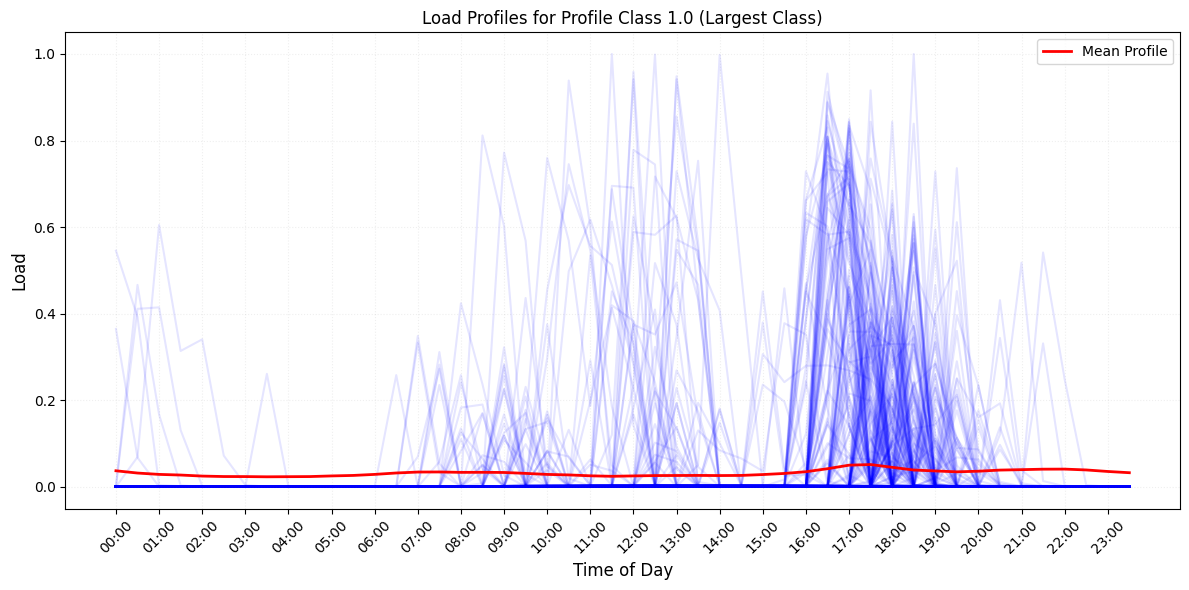

In [40]:
importlib.reload(cp)
class_sizes, fig = cp.analyze_profile_classes(rlp_aggregated, Profile_Classes)
plt.show()

In [22]:
# reset index and rename columns
Profile_Classes = Profile_Classes.reset_index()
# rename index column as Date_SiteID
Profile_Classes = Profile_Classes.rename(columns={'index': 'Date_SiteID'})

mode_of_modes = int(mode_of_modes)

df = Profile_Classes.copy()

# Step 1: Split the first column
df[["Date", "Site_ID"]] = df["Date_SiteID"].str.split("_", n=1, expand=True)

# Step 2: Modify the Profile_Class column
df["Profile_Class_Real"] = df["Profile_Class"].apply(lambda x: f"{mode_of_modes}.{int(x)}")

# Step 3: Drop intermediate column used for processing
df = df.drop(columns=["Profile_Class", "Date_SiteID", "Load_Factor"])

            Date_SiteID  Profile_Class  Load_Factor
0      2023-02-19_S0024            2.0     0.073485
1      2023-03-10_S0024            2.0     0.098069
2      2023-03-23_S0024            2.0     0.039460
3      2023-05-13_S0024            2.0     0.138028
4      2023-05-14_S0024            2.0     0.138752
...                 ...            ...          ...
25237  2023-12-25_W0352            2.0     0.110448
25238  2023-12-27_W0352            2.0     0.077800
25239  2023-12-28_W0352            2.0     0.221707
25240  2023-12-29_W0352            2.0     0.222318
25241  2023-12-31_W0352            2.0     0.214840

[25242 rows x 3 columns]


In [ ]:
#convert mode_of_modes to an integer

# Step 4: Save to CSV
df.to_csv("sub_clustering.csv", index=False)

print(df)


       Load_Factor        Date Site_ID Profile_Class_Real
0         0.073485  2023-02-19   S0024                3.2
1         0.098069  2023-03-10   S0024                3.2
2         0.039460  2023-03-23   S0024                3.2
3         0.138028  2023-05-13   S0024                3.2
4         0.138752  2023-05-14   S0024                3.2
...            ...         ...     ...                ...
25237     0.110448  2023-12-25   W0352                3.2
25238     0.077800  2023-12-27   W0352                3.2
25239     0.221707  2023-12-28   W0352                3.2
25240     0.222318  2023-12-29   W0352                3.2
25241     0.214840  2023-12-31   W0352                3.2

[25242 rows x 4 columns]


Final Outputs from this script:
- sub_clustering.csv
Next Step is to go to the regression_analysis script to create the regression model